In [1]:
import json
import pandas as pd
import re
import random
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]

    return reviews

In [9]:
def classify_it(filename, parametr): 
    i = 0
    reviews_lst_good= []
    reviews_lst_bad = []


    with open(filename, 'r') as f:
            for line in f:
                if json.loads(line)['overall'] > 3 and len(reviews_lst_good)<=500000:
                    reviews_lst_good.append (json.loads(line))

                elif json.loads(line)['overall'] < 3 and len(reviews_lst_bad)<=500000:
                    reviews_lst_bad.append (json.loads(line))

                if len(reviews_lst_good) + len (reviews_lst_bad) == 1000000:
                    break
    # random elements in the list
    random.shuffle(reviews_lst_good)
    random.shuffle(reviews_lst_bad)  
    
    reviewerID_lst = []
    reviewerName_lst = []
    reviewText_lst = []
    overall_lst = []
    summary_lst = []

    # reviews_lst [0]['overall']<5 #['asin']for 

    for i in reviews_lst_good:
#         reviewerID_lst.append (i['reviewerID'])
        reviewText_lst.append (i['reviewText'])
        overall_lst.append (i['overall'])
#         summary_lst.append (i['summary'])

    for i in reviews_lst_bad:
#         reviewerID_lst.append (i['reviewerID'])
        reviewText_lst.append (i['reviewText'])
        overall_lst.append (i['overall'])
#         summary_lst.append (i['summary'])

    df = pd.DataFrame ()

#     df['reviewerID'] = reviewerID_lst
    df['reviewText'] = reviewText_lst
    df['overall'] = overall_lst
#     df['summary'] = summary_lst
    
    df ['mark'] = 0
    df.loc[df['overall'] > 3,'mark'] = 1
    
    # 
    reviews_train = list(df[df['overall'] > 3]['reviewText'][:-100000]) + list(df[df['overall'] < 3]['reviewText'][:-100000])
    reviews_test = list(df[df['overall'] > 3]['reviewText'][-100000:]) + list(df[df['overall'] < 3]['reviewText'][-100000:])



    reviews_train_clean = preprocess_reviews(reviews_train)
    reviews_test_clean = preprocess_reviews(reviews_test)
    
    cv = TfidfVectorizer(binary=True)
    cv.fit(reviews_train_clean)
    X = cv.transform(reviews_train_clean)
    X_test = cv.transform(reviews_test_clean)
    
    y = list(df[df['overall'] > 3]['mark'][:-100000]) + list(df[df['overall'] < 3]['mark'][:-100000])
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, train_size = 0.75
    )
    
    print ('Подбор параметра для: ', filename)
    print ('    ')
    
    
    best_c_dict = {}
    main_dict = {}
    
    
    for c in [0.01, 0.05, 0.25, 0.5, 1]:
        lr = LogisticRegression(C=c)
        lr.fit(X_train, y_train)
        print ("Accuracy for C=%s: %s" 
               % (c, accuracy_score(y_val, lr.predict(X_val))))
        best_c_dict [c] = accuracy_score(y_val, lr.predict(X_val))
        main_dict [c] = [filename, accuracy_score(y_val, lr.predict(X_val))]
    
    inverse = [(value, key) for key, value in best_c_dict.items()]
    print (max(inverse)[1])

    final_model = LogisticRegression(C=best_c_dict[max(inverse)[1]])
    print ('Model use C = ', best_c_dict[max(inverse)[1]])
    final_model.fit(X,  y)
    print ("Final Accuracy: %s" 
           % accuracy_score( list(df[df['overall'] > 3]['mark'][-100000:]) + list(df[df['overall'] < 3]['mark'][-100000:])
                            , final_model.predict(X_test)))
    
    feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
        )
    }
    for best_positive in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1], 
        reverse=True)[:5]:
        print (best_positive)
    for best_negative in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1])[:5]:
        print (best_negative)
        
    del reviews_lst_good
    del reviews_lst_bad
    
    return main_dict

In [10]:
import os
import gc

os.listdir('/Volumes/GoogleDrive/Мой диск/Work/Experiment')

for i in os.listdir('/Volumes/GoogleDrive/Мой диск/Work/Experiment'):
    if i[-5:] != 'ipynb' and i != '.ipynb_checkpoints' and i == 'Electronics_5.json':
        print (i)
        print ('   ')
        dict_main = classify_it ('/Volumes/GoogleDrive/Мой диск/Work/Experiment/' + i, 0.25)
        gc.collect()
        

Electronics_5.json
   


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Подбор параметра для:  /Volumes/GoogleDrive/Мой диск/Work/Experiment/Electronics_5.json
    


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.8442921518616002
Accuracy for C=0.05: 0.8999975553509294
Accuracy for C=0.25: 0.9209074537350164
Accuracy for C=0.5: 0.9246722133037802
Accuracy for C=1: 0.9264079141439246
1
Model use C =  0.9264079141439246
Final Accuracy: 0.849685
('great', 14.031781029514045)
('excellent', 10.161637955633216)
('perfect', 9.853549337443246)
('pleased', 8.990413900419625)
('highly', 8.892696703953087)
('not', -12.237327886945932)
('returning', -11.117261103804893)
('returned', -10.962418631747452)
('return', -10.533986123599256)
('poor', -9.750627030004434)


<BarContainer object of 5 artists>

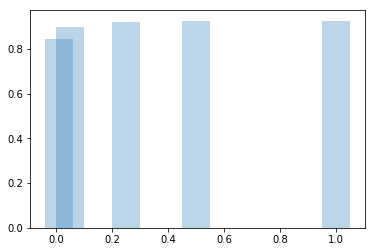

In [20]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

x_lst = []
y_lst = []
for i in dict_main:
    x_lst.append(i)
    y_lst.append(dict_main[i][1])

plt.bar(x_lst, y_lst, align='center', alpha=0.3, width=0.1)